In [8]:
import os
import sys

# Get the current working directory
current_dir = os.getcwd()

# Assume the 'src' folder is one level up from the current notebook's directory
# This might need adjustment based on your exact directory structure
project_root = os.path.abspath(os.path.join(current_dir, '..'))

# Add the project root to the Python path if it's not already there
if project_root not in sys.path:
    sys.path.append(project_root)
    print(f"Added '{project_root}' to sys.path.")

In [9]:
# =============================================================================
# 01_ecommerce_fraud_eda_preprocessing.ipynb
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Import functions from src
from src.data_cleaning import clean_ecommerce_data
from src.ip_to_country_mapper import map_ips_to_countries
from src.feature_engineering import create_ecommerce_features
from src.model_utils import preprocess_for_modeling # We'll call this at the very end of preprocessing

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("Libraries and custom modules loaded successfully!")

Libraries and custom modules loaded successfully!


In [11]:
# --- Load Data ---
print("\n--- Loading Data ---")
try:
    df_fraud = pd.read_csv('../data/Fraud_Data.csv')
    df_ip_country = pd.read_csv('../data/IpAddress_to_Country.csv')
    print("Fraud_Data.csv and IpAddress_to_Country.csv loaded.")
except FileNotFoundError:
    print("Error: Ensure 'data' folder is in the parent directory and contains the CSV files.")
    raise # Re-raise to stop execution if data is missing

print("Fraud_Data shape:", df_fraud.shape)
print("IpAddress_to_Country shape:", df_ip_country.shape)

# Display head to understand columns
print("\nFraud_Data Head:")
print(df_fraud.head())
print("\nIpAddress_to_Country Head:")
print(df_ip_country.head())


--- Loading Data ---
Fraud_Data.csv and IpAddress_to_Country.csv loaded.
Fraud_Data shape: (151112, 11)
IpAddress_to_Country shape: (138846, 3)

Fraud_Data Head:
   user_id          signup_time        purchase_time  purchase_value  \
0    22058  2015-02-24 22:55:49  2015-04-18 02:47:11              34   
1   333320  2015-06-07 20:39:50  2015-06-08 01:38:54              16   
2     1359  2015-01-01 18:52:44  2015-01-01 18:52:45              15   
3   150084  2015-04-28 21:13:25  2015-05-04 13:54:50              44   
4   221365  2015-07-21 07:09:52  2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class  
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0  
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1  
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0  
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0  

IpAddress_to_Countr

In [12]:
# =============================================================================
# Task 1 - Data Analysis and Preprocessing
# =============================================================================

# --- Handle Missing Values & Data Cleaning ---
# Using the function from src/data_cleaning.py
df_fraud = clean_ecommerce_data(df_fraud.copy()) # Use .copy() to avoid SettingWithCopyWarning if you pass slice later

Starting e-commerce data cleaning...
Removed 0 duplicate rows.
Converted 'signup_time' and 'purchase_time' to datetime objects.
Converted source, browser, sex to 'category' type.
E-commerce data cleaning complete.



--- Exploratory Data Analysis (Fraud_Data) ---


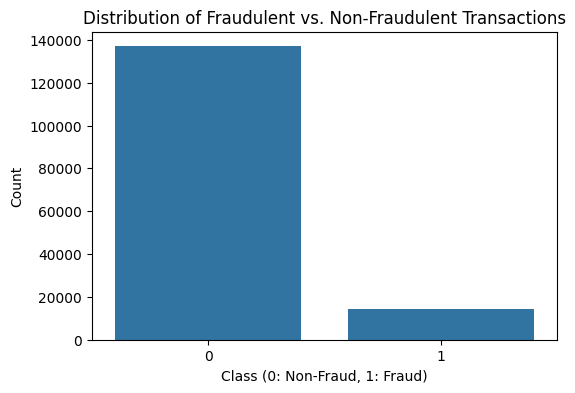


Class Distribution:
class
0    90.635423
1     9.364577
Name: proportion, dtype: float64
Class Imbalance: Fraudulent transactions make up 9.3646% of the data.


In [13]:
# =============================================================================
# Exploratory Data Analysis (EDA) - (Keep in notebook for visualization)
# =============================================================================
print("\n--- Exploratory Data Analysis (Fraud_Data) ---")

# Target variable distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='class', data=df_fraud)
plt.title('Distribution of Fraudulent vs. Non-Fraudulent Transactions')
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Count')
plt.show()

fraud_percentage = df_fraud['class'].value_counts(normalize=True) * 100
print(f"\nClass Distribution:\n{fraud_percentage}")
print(f"Class Imbalance: Fraudulent transactions make up {fraud_percentage[1]:.4f}% of the data.")

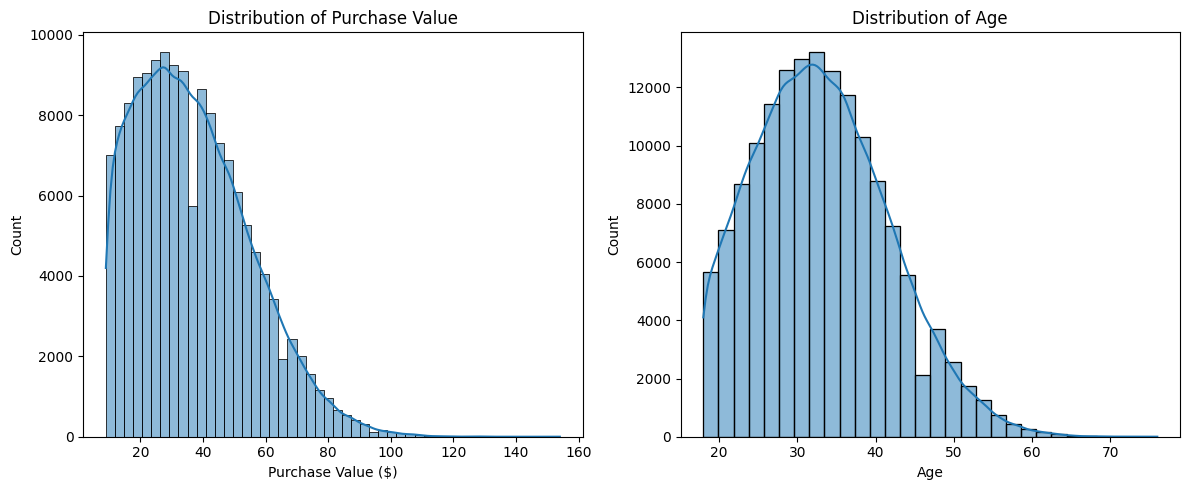


Purchase Value Statistics:
count    151112.000000
mean         36.935372
std          18.322762
min           9.000000
25%          22.000000
50%          35.000000
75%          49.000000
max         154.000000
Name: purchase_value, dtype: float64

Age Statistics:
count    151112.000000
mean         33.140704
std           8.617733
min          18.000000
25%          27.000000
50%          33.000000
75%          39.000000
max          76.000000
Name: age, dtype: float64


In [14]:
# Univariate analysis for numerical features
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_fraud['purchase_value'], bins=50, kde=True)
plt.title('Distribution of Purchase Value')
plt.xlabel('Purchase Value ($)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.histplot(df_fraud['age'], bins=30, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

print("\nPurchase Value Statistics:")
print(df_fraud['purchase_value'].describe())
print("\nAge Statistics:")
print(df_fraud['age'].describe())

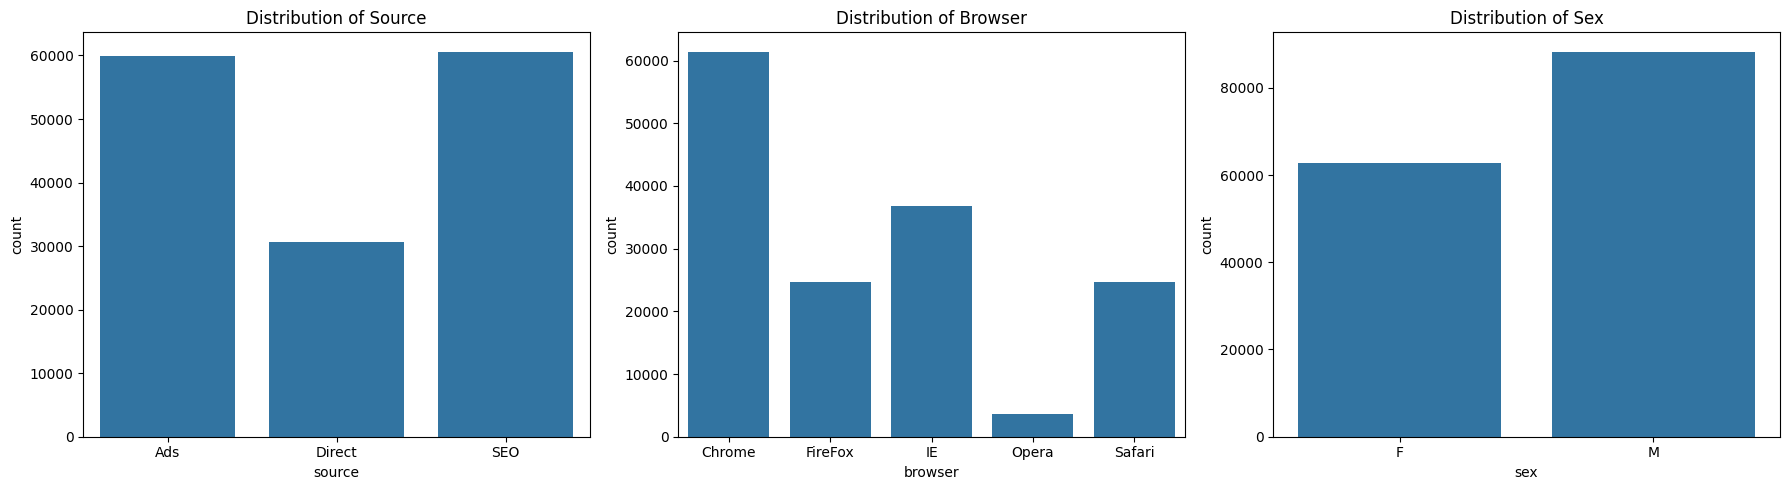

In [15]:
# Univariate analysis for categorical features
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.countplot(x='source', data=df_fraud, ax=axes[0])
axes[0].set_title('Distribution of Source')
sns.countplot(x='browser', data=df_fraud, ax=axes[1])
axes[1].set_title('Distribution of Browser')
sns.countplot(x='sex', data=df_fraud, ax=axes[2])
axes[2].set_title('Distribution of Sex')
plt.tight_layout()
plt.show()

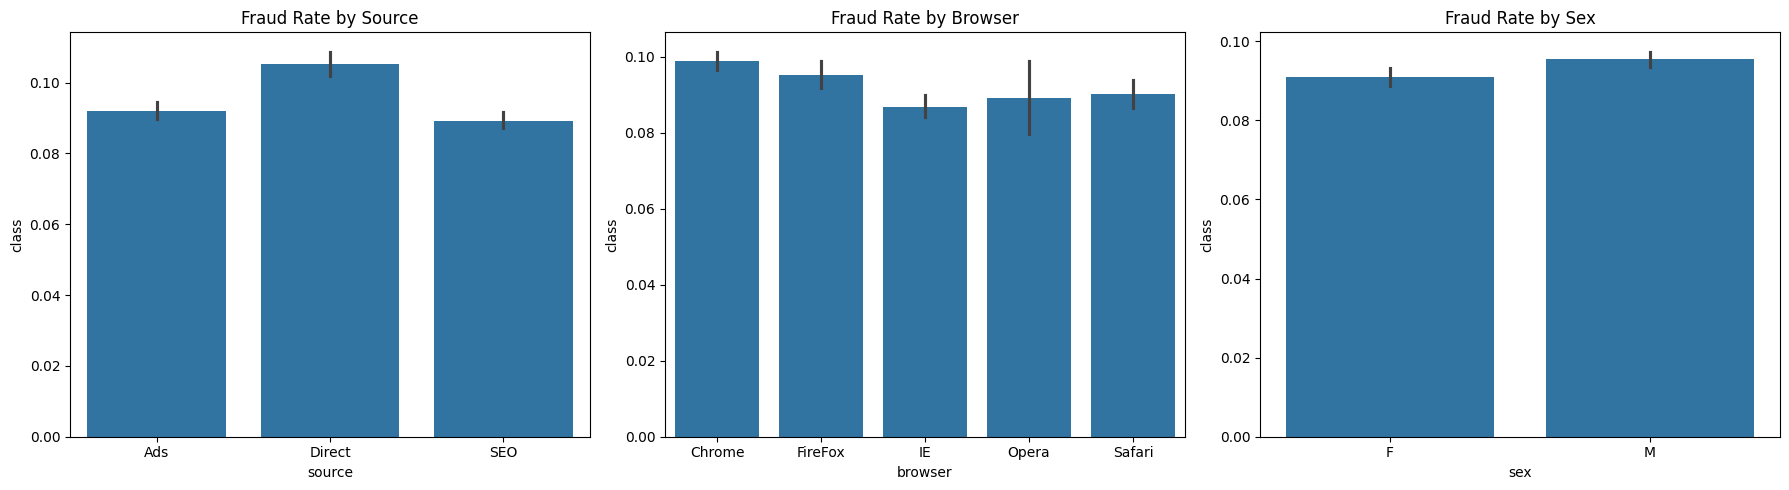

In [16]:
# Bivariate analysis: Fraud rate by categorical features
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.barplot(x='source', y='class', data=df_fraud, ax=axes[0], estimator=np.mean)
axes[0].set_title('Fraud Rate by Source')
sns.barplot(x='browser', y='class', data=df_fraud, ax=axes[1], estimator=np.mean)
axes[1].set_title('Fraud Rate by Browser')
sns.barplot(x='sex', y='class', data=df_fraud, ax=axes[2], estimator=np.mean)
axes[2].set_title('Fraud Rate by Sex')
plt.tight_layout()
plt.show()

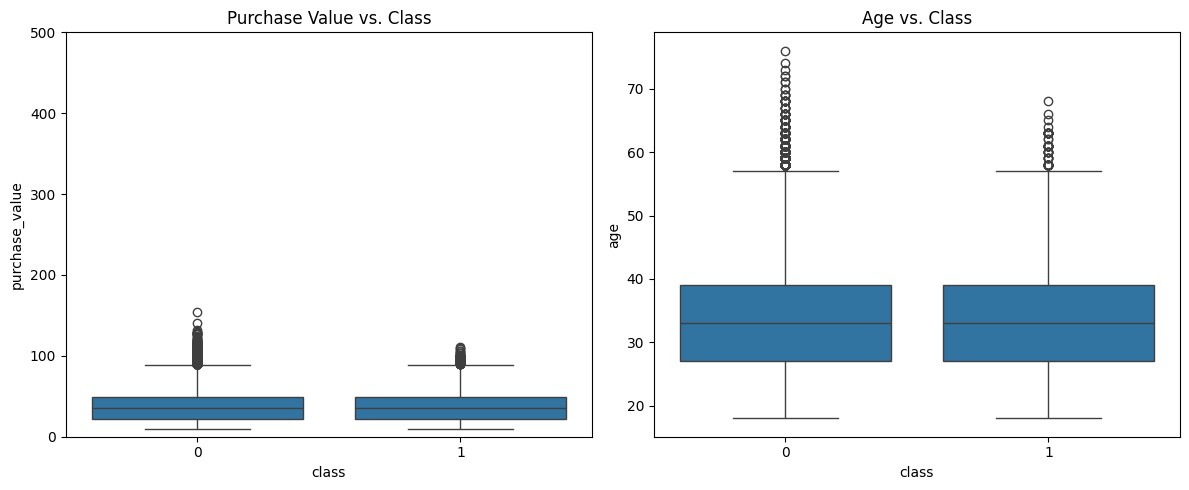

In [17]:
# Bivariate analysis: Fraud rate by numerical features (using violin plot or kde)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='class', y='purchase_value', data=df_fraud)
plt.title('Purchase Value vs. Class')
plt.ylim(0, 500) # Limit y-axis for better visualization if there are outliers

plt.subplot(1, 2, 2)
sns.boxplot(x='class', y='age', data=df_fraud)
plt.title('Age vs. Class')
plt.tight_layout()
plt.show()

In [18]:
# --- Merge Datasets for Geolocation Analysis ---
# Using the function from src/ip_to_country_mapper.py
df_fraud = map_ips_to_countries(df_fraud.copy(), df_ip_country.copy())

print("\nFraud_Data with new 'country' column head:")
print(df_fraud.head())
print("\nDistribution of 'country' (top 10):")
print(df_fraud['country'].value_counts().head(10))

Starting IP to Country mapping...
IP addresses converted to integer format.


Mapping IPs to Countries: 100%|██████████| 151112/151112 [00:00<00:00, 1248824.52it/s]

IP to Country mapping complete.

Fraud_Data with new 'country' column head:
   user_id         signup_time       purchase_time  purchase_value  \
0    22058 2015-02-24 22:55:49 2015-04-18 02:47:11              34   
1   333320 2015-06-07 20:39:50 2015-06-08 01:38:54              16   
2     1359 2015-01-01 18:52:44 2015-01-01 18:52:45              15   
3   150084 2015-04-28 21:13:25 2015-05-04 13:54:50              44   
4   221365 2015-07-21 07:09:52 2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class  ip_address_int  \
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0             NaN   
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0             NaN   
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1             NaN   
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0             NaN   
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0             NaN   

   country  
0  

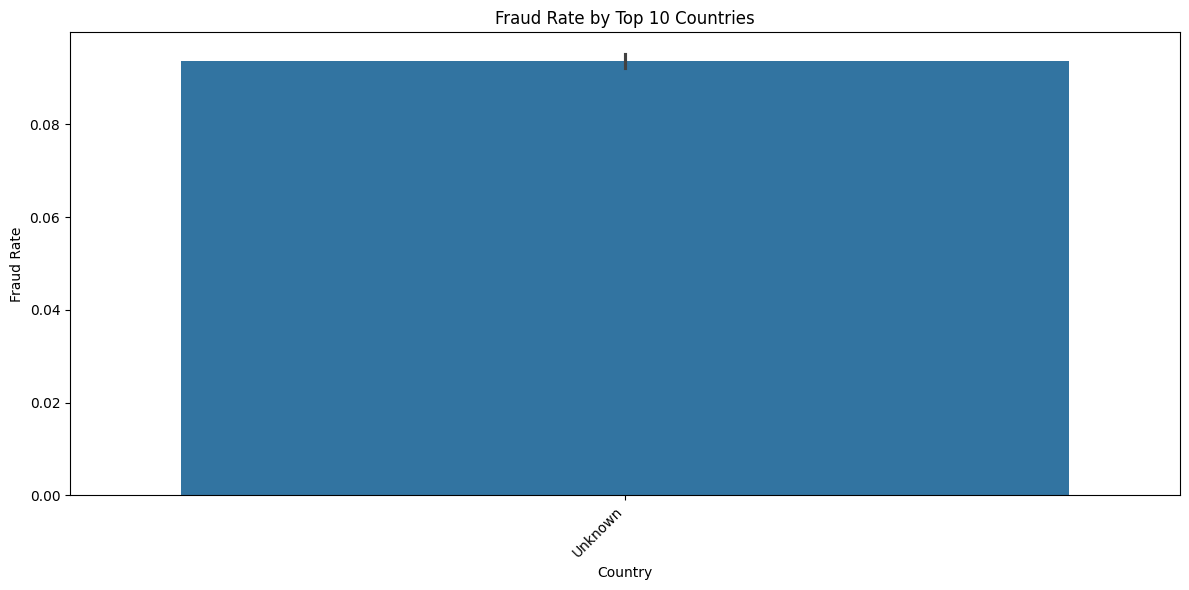

In [19]:
# Bivariate analysis: Fraud rate by country (top 10)
plt.figure(figsize=(12, 6))
top_countries = df_fraud['country'].value_counts().head(10).index
sns.barplot(x='country', y='class', data=df_fraud[df_fraud['country'].isin(top_countries)], estimator=np.mean)
plt.title('Fraud Rate by Top 10 Countries')
plt.xlabel('Country')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [20]:
# --- Feature Engineering ---
# Using the function from src/feature_engineering.py
df_fraud = create_ecommerce_features(df_fraud.copy())

print("\nFraud_Data with new engineered features head:")
print(df_fraud[['purchase_time', 'signup_time', 'hour_of_day', 'day_of_week', 'time_since_signup_hours',
               'user_transaction_count', 'device_transaction_count', 'ip_transaction_count',
               'user_unique_devices', 'user_unique_ips', 'device_unique_users', 'ip_unique_users']].head())

Starting feature engineering for e-commerce data...
Created 'hour_of_day', 'day_of_week', 'day_of_year'.
Created 'time_since_signup_hours'.
Created transaction count features for user, device, and IP.
Created user's unique device/IP count features.
Created device/IP's unique user count features.
E-commerce feature engineering complete.

Fraud_Data with new engineered features head:
        purchase_time         signup_time hour_of_day day_of_week  \
0 2015-04-18 02:47:11 2015-02-24 22:55:49           2           5   
1 2015-06-08 01:38:54 2015-06-07 20:39:50           1           0   
2 2015-01-01 18:52:45 2015-01-01 18:52:44          18           3   
3 2015-05-04 13:54:50 2015-04-28 21:13:25          13           0   
4 2015-09-09 18:40:53 2015-07-21 07:09:52          18           2   

   time_since_signup_hours  user_transaction_count  device_transaction_count  \
0              1251.856111                       1                         1   
1                 4.984444              

In [24]:
# --- Data Transformation (Preparation for Modeling) ---
# Separate features and target
features_to_drop_eco = ['user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address']
X_ecommerce = df_fraud.drop(columns=features_to_drop_eco + ['class'])
y_ecommerce = df_fraud['class']

print("\nFeatures selected for modeling (E-commerce):")
print(X_ecommerce.head())
print("\nTarget variable (E-commerce):")
print(y_ecommerce.head())

# =========================================================================
# CRITICAL: Re-evaluate numerical_features_ecommerce *after* X_ecommerce is defined
# And ensure ip_address_int is properly handled
# =========================================================================

# Define categorical and numerical features based on the *current* X_ecommerce
# This needs to happen *before* the imputation step, but *after* dropping columns
# This ensures 'ip_address_int' is present in X_ecommerce for the check.
categorical_features_ecommerce = [col for col in X_ecommerce.select_dtypes(include='category').columns]
numerical_features_ecommerce = [col for col in X_ecommerce.select_dtypes(include=np.number).columns] # This should now include 'ip_address_int' if its dtype is numeric (e.g., float64)

print("\n--- Handling NaN values in numerical features before preprocessing ---")
# Identify numerical columns that might contain NaNs from the currently defined numerical features list
numerical_cols_with_nans = [col for col in numerical_features_ecommerce if X_ecommerce[col].isnull().any()]

if not numerical_cols_with_nans:
    print("No numerical columns with NaNs found. Skipping imputation.")
else:
    for col in numerical_cols_with_nans:
        # Check if the median is NaN (meaning the column is all NaNs)
        median_val = X_ecommerce[col].median()
        if pd.isna(median_val):
            # If median is NaN, it means the column is entirely NaN.
            # In such cases, impute with 0 or a specific indicator value like -1.
            # Choosing 0 here, assuming a non-existent IP maps to 0 if it's a count,
            # or a default value if it's an ID. Adjust if -1 is more appropriate.
            X_ecommerce[col] = X_ecommerce[col].fillna(0)
            print(f"Column '{col}' was entirely NaN. Filled with 0.")
        else:
            # Otherwise, fill with the calculated median
            X_ecommerce[col] = X_ecommerce[col].fillna(median_val)
            print(f"Filled NaN in '{col}' with median value: {median_val}")

# Verify no more NaNs in numerical columns
# We use the refreshed numerical_features_ecommerce list here
print(f"NaNs remaining in numerical features after imputation: {X_ecommerce[numerical_features_ecommerce].isnull().sum().sum()}")
# =========================================================================

# The rest of the cell remains the same, but now it operates on a cleaned X_ecommerce
# with proper numerical and categorical feature lists.

# Call the preprocess_for_modeling function from src/model_utils.py
X_train_eco_resampled, X_test_eco, y_train_eco_resampled, y_test_eco, ecommerce_feature_names = \
    preprocess_for_modeling(X_ecommerce.copy(), y_ecommerce.copy(),
                            numerical_features_ecommerce, categorical_features_ecommerce,
                            random_state=42)

# Ensure X_test_eco has column names (needed for SHAP)
X_test_eco = pd.DataFrame(X_test_eco, columns=ecommerce_feature_names)
X_train_eco_resampled = pd.DataFrame(X_train_eco_resampled, columns=ecommerce_feature_names)


Features selected for modeling (E-commerce):
   purchase_value source browser sex  age  ip_address_int  country  \
0              34    SEO  Chrome   M   39             NaN  Unknown   
1              16    Ads  Chrome   F   53             NaN  Unknown   
2              15    SEO   Opera   M   53             NaN  Unknown   
3              44    SEO  Safari   M   41             NaN  Unknown   
4              39    Ads  Safari   M   45             NaN  Unknown   

  hour_of_day day_of_week  day_of_year  time_since_signup_hours  \
0           2           5          108              1251.856111   
1           1           0          159                 4.984444   
2          18           3            1                 0.000278   
3          13           0          124               136.690278   
4          18           2          252              1211.516944   

   user_transaction_count  device_transaction_count  ip_transaction_count  \
0                       1                         1  

In [25]:
def map_ips_to_countries(df_fraud, df_ip_country):
    # ... existing code ...

    # Convert IP addresses to integer for mapping/feature engineering later
    # This will introduce NaNs for unconvertible IPs
    # Use errors='coerce' to turn invalid parsing into NaN
    df_fraud['ip_address_int'] = df_fraud['ip_address'].apply(
        lambda x: int(x) if pd.notna(x) else np.nan
    )

    # ... rest of the function ...
    return df_fraud

In [26]:
# Save preprocessed dataframes for model training notebook
import pickle
with open('../data/processed_ecommerce_data.pkl', 'wb') as f:
    pickle.dump({
        'X_train_resampled': X_train_eco_resampled,
        'y_train_resampled': y_train_eco_resampled,
        'X_test': X_test_eco,
        'y_test': y_test_eco,
        'feature_names': ecommerce_feature_names
    }, f)
print("\nPreprocessed E-commerce data saved to ../data/processed_ecommerce_data.pkl")

print("\nE-commerce Data Preprocessing Complete!")


Preprocessed E-commerce data saved to ../data/processed_ecommerce_data.pkl

E-commerce Data Preprocessing Complete!


In [27]:
# Save preprocessed dataframes for model training notebook
import pickle
with open('../data/processed_ecommerce_data.pkl', 'wb') as f:
    pickle.dump({
        'X_train_resampled': X_train_eco_resampled,
        'y_train_resampled': y_train_eco_resampled,
        'X_test': X_test_eco,
        'y_test': y_test_eco,
        'feature_names': ecommerce_feature_names
    }, f)
print("\nPreprocessed E-commerce data saved to ../data/processed_ecommerce_data.pkl")

print("\nE-commerce Data Preprocessing Complete!")


Preprocessed E-commerce data saved to ../data/processed_ecommerce_data.pkl

E-commerce Data Preprocessing Complete!
